# **GenAI Task**

✅ Convert grayscale Fashion-MNIST images to RGB.

✅ Train a VAE to learn a latent space representation and generate images.

✅ Train a DCGAN to generate high-quality fashion images.

✅ Generated images are in color (RGB) instead of grayscale.

# **Step 1: Preprocessing**

- **Load Fashion-MNIST dataset.**

- **Convert grayscale (1 channel) → RGB (3 channels).**

  
- **Normalize the images to the range [-1, 1] for better GAN performance.**

In [1]:
import tensorflow as tf
import numpy as np

# Load Fashion-MNIST dataset
(x_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

# Convert grayscale (1 channel) to RGB (3 channels)
x_train = np.stack([x_train] * 3, axis=-1)  # Convert (28,28,1) → (28,28,3)
x_train = x_train.astype("float32") / 255.0  # Normalize to [0,1]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# **Step 2: Train VAE**

**A VAE consists of:**

1. **Encoder**: Compresses the image into a lower-dimensional latent space.
2. **Latent** Space Sampling: Uses mean and variance to sample points.
3. **Decoder**: Reconstructs an image from the latent space.

In [2]:
from tensorflow.keras import layers, Model

latent_dim = 64  # Dimension of latent space

# Encoder
inputs = layers.Input(shape=(28, 28, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

# Sampling Function
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)  # RGB Output

# Define Models
encoder = Model(inputs, [z_mean, z_log_var, z])
decoder = Model(latent_inputs, outputs)

# Full VAE Model
vae = Model(inputs, decoder(encoder(inputs)[2]))
vae.compile(optimizer="adam", loss="mse")

In [4]:
# Train VAE
vae.fit(x_train, x_train, epochs=10, batch_size=128)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0599
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0139
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0111
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0096
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0088
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0082
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0077
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0074
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0071
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0068


# **Step 3: Train DCGAN**

- **A DCGAN consists of:**

1. **Generator**: Creates fake images from random noise.

2. **Discriminator**: Classifies images as real or fake.

3. **Adversarial Training**: The Generator learns to create realistic images by fooling the Discriminator.

## **3.1 Building the Generator**

In [5]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(7 * 7 * 256, activation="relu", input_shape=(100,)),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same", activation="relu"),
        layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="relu"),
        layers.Conv2DTranspose(3, kernel_size=3, padding="same", activation="tanh")  # RGB Output
    ])
    return model

generator = build_generator()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## **3.2 Building the Discriminator**

In [6]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, kernel_size=3, strides=2, padding="same", input_shape=(28, 28, 3)),
        layers.LeakyReLU(0.2),
        layers.Conv2D(128, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")  # Binary classification (real/fake)
    ])
    return model

discriminator = build_discriminator()
discriminator.compile(optimizer="adam", loss="binary_crossentropy")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## **3.3 Training the DCGAN**

In [11]:
# GAN Model: Connect Generator & Discriminator
z_dim = 100
gan_input = layers.Input(shape=(z_dim,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)
gan.compile(optimizer="adam", loss="binary_crossentropy")

# Initialize loss tracking lists
d_losses = []
g_losses = []

# Training DCGAN
batch_size = 128
epochs = 500  

for epoch in range(epochs):
    # Generate fake images
    noise = np.random.normal(0, 1, (batch_size, z_dim))
    fake_images = generator.predict(noise)

    # Get real images
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_images = x_train[idx]

    # Labels for real and fake images
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    # Train Discriminator
    d_loss_real = discriminator.train_on_batch(real_images, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
    d_loss = np.mean(d_loss_real) + np.mean(d_loss_fake)  # Compute total D loss

    # Train Generator via GAN
    noise = np.random.normal(0, 1, (batch_size, z_dim))
    g_loss = gan.train_on_batch(noise, real_labels)

    # Store losses
    d_losses.append(d_loss)
    g_losses.append(np.mean(g_loss))

    # Print progress every 20 epochs
    if epoch % 20 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss:.4f} | G Loss: {np.mean(g_loss):.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/500 | D Loss: 1.0326 | G Loss: 0.5157
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 21/500 | D Loss: 1.0526 | G Loss: 0.5275
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

## **3.4 Loss Visualization**

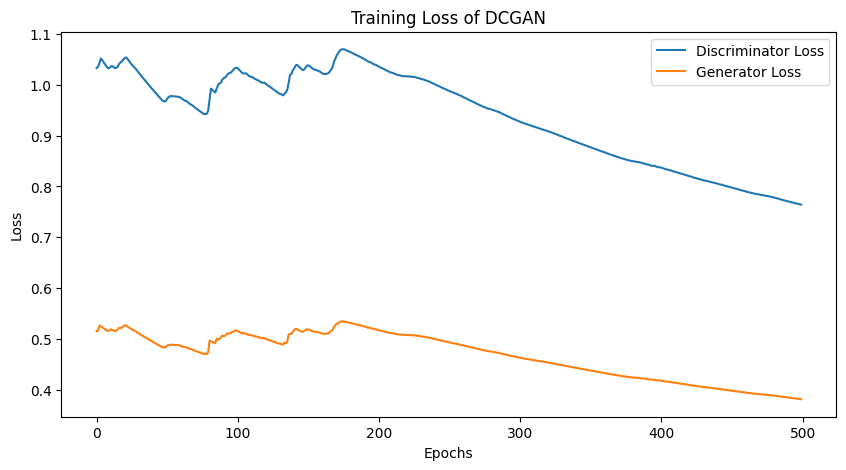

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss of DCGAN")
plt.legend()
plt.show()

## **3.5 Display a Generated Image**


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Generated image shape: (1, 28, 28, 3)


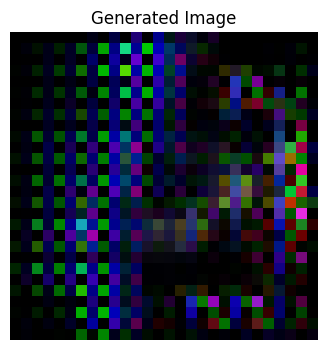

In [16]:
import matplotlib.pyplot as plt

# Generate a random noise vector
noise = np.random.normal(0, 1, (1, z_dim))  # Single random noise input

# Generate an image using the trained Generator
generated_image = generator.predict(noise)

# Check the shape
print("Generated image shape:", generated_image.shape)

# Remove batch dimension
generated_image_colored = generated_image[0]  # Shape becomes (28, 28, 3)

# Display the image
plt.figure(figsize=(4, 4))
plt.imshow(generated_image_colored)  # No need for cmap since it's RGB
plt.axis("off")
plt.title("Generated Image")
plt.show()
